In [1]:
import os
import numpy as np
import torch
from torchvision.io import read_image
from torch.utils.data import DataLoader, SubsetRandomSampler
from PIL import Image
import matplotlib.pyplot as plt
import albumentations as A

In [2]:
from dataset import LitographyDataset

In [3]:
img_dir = '/root/datasets/train/images/'
mask_dir = '/root/datasets/train/labels/'

In [4]:
dataset = LitographyDataset(img_dir, mask_dir)

# DATASET TESTING

In [5]:
aug = A.Compose([
    A.RandomBrightnessContrast(p=0.8),
    A.RandomGamma(p=0.8),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate()
])

In [6]:
dataset = LitographyDataset(img_dir, mask_dir, aug)

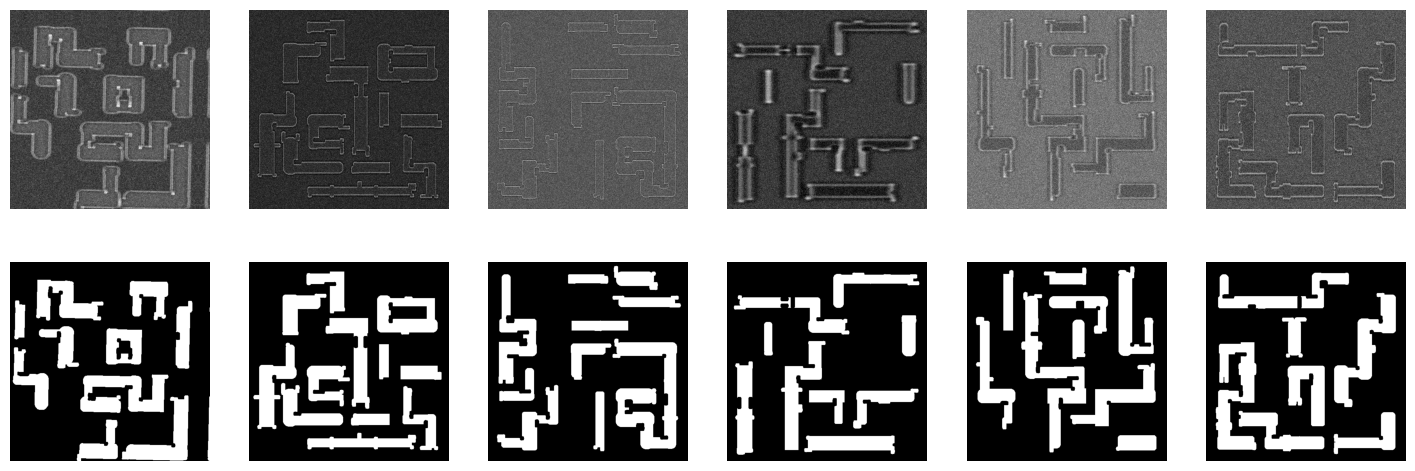

In [8]:
plt.figure(figsize=(18, 6))
for i in range(6):
    image, mask = dataset[i]
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(image.cpu().numpy()[0], cmap="gray")

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(mask.cpu().numpy()[0], cmap="gray")
plt.show()

# DATALOADERS AND TRAIN/TEST SPLIT

In [9]:
ix = np.random.choice(len(dataset), len(dataset), False)
tr, val, ts = np.split(ix, [int(len(dataset)*0.8), int(len(dataset)*0.9)])

In [10]:
print(len(tr), len(val), len(ts))

12000 1500 1500


In [11]:
batch_size = 32

train_sampler = SubsetRandomSampler(indices=tr)
val_sampler = SubsetRandomSampler(indices=val)
test_sampler = SubsetRandomSampler(indices=ts)

data_tr = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size)
data_val = DataLoader(dataset, sampler=val_sampler, batch_size=batch_size)
data_ts = DataLoader(dataset, sampler=test_sampler, batch_size=batch_size)

# TRAIN

In [12]:
from engine import train, bce_loss
from model import UNet

In [13]:
GPU = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(GPU)

cuda


In [14]:
unet_model = UNet().to(GPU)

/usr/local/lib/python3.10/dist-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


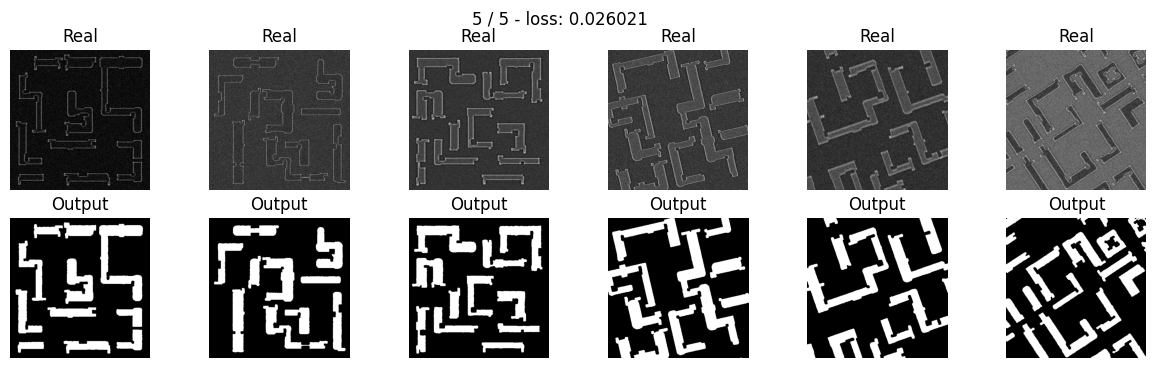

In [15]:
max_epochs = 5

optim = torch.optim.AdamW(unet_model.parameters(), amsgrad=True, lr=1e-2)

train_loss, val_loss = train(unet_model, optim, bce_loss, max_epochs, data_tr, data_val, device=GPU)

In [17]:
torch.save(unet_model.state_dict(), 'weights/UNET_5EPOCHS_BCE_NO_SCHED.pth')

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(model_losses['unet - pooling - focal'][0][:], label="train_loss")
plt.plot(model_losses['unet - pooling - focal'][1][:], label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()